In [ ]:
#-------------------------------------------------------------------------------
# THE NAMES OF THE TEAM MEMBERS

# Ammendola Giovanni - 0622701167
# Petrone Vincenzo - 0622701134
# Valitutto Andrea - 0622701366
# Ventre Salvatore - 0622701343

#-------------------------------------------------------------------------------

To correctly use this collab notebook, please run all the cells until paragraph 2.2 excluded. Sections from 2.2 to 2.5 can be executed independently.

# 1. Initialization

## 1.1 Colab Setup

Connect the Notebook to a Google Drive account

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Now go to the appropriate folder on your google drive. Note: you may need to change the folder name, depending on where on your drive you have the data files.

In [2]:
import os
home = '/content/drive/My Drive/ProgettoSDA2020/Codice/Colab'
os.chdir(home)

Ignore annoying warnings

In [3]:
import warnings
warnings.filterwarnings("ignore");

Make the plots look better

In [4]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

## 1.2 Spark Setup

Download

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# The no check certificate parameter is required since the commands returns an error
!wget --no-check-certificate  https://mirror.nohup.it/apache/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop2.7.tgz
!tar xf spark-3.0.0-preview2-bin-hadoop2.7.tgz
!rm spark-3.0.0-preview2-bin-hadoop2.7.tgz
!pip install -q findspark

--2020-07-07 13:20:04--  https://mirror.nohup.it/apache/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop2.7.tgz
Resolving mirror.nohup.it (mirror.nohup.it)... 81.29.196.51
Connecting to mirror.nohup.it (mirror.nohup.it)|81.29.196.51|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 234760295 (224M) [application/x-gzip]
Saving to: ‘spark-3.0.0-preview2-bin-hadoop2.7.tgz’

spark-3.0.0-preview 100%[===================>] 223.88M  4.09MB/s    in 51s     

2020-07-07 13:20:56 (4.37 MB/s) - ‘spark-3.0.0-preview2-bin-hadoop2.7.tgz’ saved [234760295/234760295]



Initialization

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = home + "/spark-3.0.0-preview2-bin-hadoop2.7"

import findspark
findspark.init()

import pyspark
# The number of clusters is just an example since we are using a single machine
NCluster = 4
conf = pyspark.SparkConf().setMaster(f"local[{NCluster}]").setAppName('SDAProject2020Spark')
sc = pyspark.SparkContext(conf=conf)

ValueError: ignored

## 1.3 DataSet

Now open the dataset and get its dimensions.


In [5]:
import pandas as pd
data = pd.read_csv("dataset.csv")

N = len(data)
n = [None]*2

# Saving the number of recommended and not recommended airlines
for rec in [0,1]:
    isrec = data['recommended'] == rec
    n[rec] = len(data[isrec])

Normalize the data

In [6]:
features = [data.columns[i] for i in range(4,12)]
for column in features:
    data[column] = data[column] / max(data[column])

View the first data rows

In [7]:
data.head()

,Unnamed: 0,airline,traveller_type,class,overall,seat_comfort,cabin_service,food_bev,entertainment,ground_service,wifi_connectivity,value_for_money,recommended
0,1,adria airways,NaN,Economy,0.5,0.2,0.8,0.8,0.2,1.0,0.2,0.8,1
1,2,adria airways,NaN,Economy,0.9,0.8,1.0,0.8,0.6,0.8,0.6,0.8,1
2,3,adria airways,NaN,Economy,0.5,0.6,0.8,0.6,0.8,0.6,0.8,0.8,1
3,4,adria airways,NaN,Economy,0.7,0.8,0.8,0.8,0.6,0.6,0.8,0.8,1
4,5,adria airways,NaN,Economy,0.7,0.6,0.4,0.2,0.2,0.8,0.2,0.2,1


Access a single row

In [8]:
from random import randint

index = randint(0, len(data)-1)

print(f'Accessing index {index}...\n')
print(data.iloc[index, 1:])

print('\n\nAccessing only airline and overall fields...\n')
print(data.loc[index, ['airline','overall']])

Accessing index 52040...

airline              pia pakistan international airlines
traveller_type                                       NaN
class                                            Economy
overall                                              0.8
seat_comfort                                         0.8
cabin_service                                          1
food_bev                                             0.6
entertainment                                          1
ground_service                                       0.8
wifi_connectivity                                      1
value_for_money                                      0.8
recommended                                            1
Name: 52040, dtype: object


Accessing only airline and overall fields...

airline    pia pakistan international airlines
overall                                    0.8
Name: 52040, dtype: object


## 1.4 Utility functions

In [12]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


def plot_gaussian_3D(mean, cov, xlim=[0,1], ylim=[0,1], xlabel='X Label', ylabel='Y Label', title='Z', cmap=cm.jet):
    """This codes makes a trick analogue to the use of meshgrid in MATLAB.
    It builds the contour plot of a bivariate Gaussian distribution
    having mean vector and covariance matrix specified in the arguments."""
    # step 1: create the grid
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
    # step 2: stack the grid
    xx_yy = np.dstack((xx, yy))
    # step 3: build the plot
    rv = multivariate_normal(mean, cov)
    # step 4: Make a 3D plot
    pos = np.empty(xx.shape + (2,))
    pos[:, :, 0] = xx
    pos[:, :, 1] = yy
    ax = plt.gca(projection='3d')
    ax.plot_surface(xx, yy, rv.pdf(pos), cmap=cmap, linewidth=0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)


def print_fit_performance(Ytest, Yestimated):
    print('Performance...\n')
    print('Confusion matrix:')
    print(confusion_matrix(Ytest, Yestimated))
    print('\n\nClassifier performance metrics:')
    print(classification_report(Ytest, Yestimated))


def parabolic_curve(n, a=1, b=0, c=0):
    """Generates n points on a parabolic curve defined by the values passed as 
      parameters. Returned values are integers."""
    # generating the points on the curve
    curve = [int(a * x**2 + b*x + c) for x in range(n)]

    # removing identical consecutive values
    for i in range(1,len(curve)):
        curve[i] = max(curve[i-1]+1, curve[i])
        
    return curve


def parabolic_curve_float(n, a=1, b=0, c=0, precision=4):
    """Generates n points on a parabolic curve defined by the values passed as 
    parameters. Returned values are floats."""
	# generating the points on the curve
    curve = [round(a*x**2 + b*x + c, precision) for x in range(n)]

    # removing identical consecutive values depending on precision
    for i in range(1, len(curve)):
        curve[i] = round(max(curve[i-1] + 10**(-precision), curve[i]), precision)

    return curve


def most_common(x):
    """Returns the most common value in a dictionary"""
    return max(set(x), key=list(x).count)


def train_test_val_split(X, Y, test_size=0.3, val_size=0.2):
    """Split the dataset into 3 parts, train, validation and test set."""
    if not 0 < test_size < 1 or not 0 < val_size < 1:
        raise ValueError("test_size and val_size must be in ]0,1[")

    if not test_size + val_size < 1:
        raise ValueError("the sum of test_size and val_size must be less than 1")

    # first split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size+val_size)

    # second split, rescaling the split size to match 1
    val_size /= val_size + test_size
    X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=val_size)

    return X_train, X_test, X_val, Y_train, Y_test, Y_val


def plot_sigmoid(XX, YY, w, title='Decision Regions'):
    """Given w, plot the controur filled plot of the sigmoid function: 1/(1+e^(-w[0]-w[1]*x-w[2]*y))
    in a certain range of x and y."""

    f = plt.figure()

    # step 0: plot the training set
    plt.scatter(XX[:, 0], XX[:, 1], c=YY, cmap='RdBu')
    # step 1: get the boundaries of the grid
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # step 2: create the grid
    yy, xx = np.meshgrid(np.linspace(ylim[0], ylim[1], 30), np.linspace(xlim[0], xlim[1], 30))
    # step 3: compute the function values for any x in xx and y in yy
    pp = np.divide(1, 1 + np.exp(- w[0] - w[1]*xx - w[2]*yy));  
    # step 4: plot decision boundary and margin
    contour = ax.contourf(xx, yy, pp, 25, cmap="RdBu", alpha=0.6,
                          levels=[i/10 for i in range(11)], zorder=0)
    ax.set_title(title)
    f.colorbar(contour)
    plt.show()

# 2. Data Analysis

## 2.1 Basic Analysis

### 2.1.1 DataSet distribution

Analysis of dataset distribution.
We can see that it is quite well balanced between recommended and not recommeded airlines

In [13]:
for rec in [0,1]:
    print(f'{rec}: {n[rec] / N * 100: .2f}%')

0:  50.41%
1:  49.59%


### 2.1.2 Mean and variance of two example features

Analysis of overall and value for money mean and variance for both recommended and not recommeded airline

In [14]:
# These values will be used to train the predictors with only two features
f1_name = 'overall'
f2_name = 'value_for_money'

f1 = [None]*2
f2 = [None]*2

mean = {
    f1_name: [None]*2,
    f2_name: [None]*2,
}
var = {
    f1_name: [None]*2,
    f2_name: [None]*2,
}
# since recommended is a binary value, it can be represented as a 0 or a 1
for rec in [0,1]:
    # selecting all the rows that have the column recommended set to 0,
    # then to 1. The selection is executed with the pandas library
    isrec = data['recommended'] == rec
    # saving the two rows in two lists
    f1[rec] = data[isrec][f1_name]
    f2[rec] = data[isrec][f2_name]
    # computing mean and variance of the selected features (f1 and f2)
    mean[f1_name][rec] = f1[rec].mean()
    var[f1_name][rec] = f1[rec].var()
    mean[f2_name][rec] = f2[rec].mean()
    var[f2_name][rec] = f2[rec].var()

m = mean[f1_name]
v = var[f1_name]
print(f'For recommeded airlines, the {f1_name} mean is {m[1]:.4f} with variance {v[1]:.4f}\n'
      f'For not recommeded airlines, the {f1_name} mean is {m[0]:.4f} with variance {v[0]:.4f}')

m = mean[f2_name]
v = var[f2_name]
print(f'\nFor recommeded airlines, the {f2_name} mean is {m[1]:.4f} with variance {v[1]:.4f}\n'
      f'For not recommeded airlines, the {f2_name} mean is {m[0]:.4f} with variance {v[0]:.4f}')

For recommeded airlines, the overall mean is 0.8334 with variance 0.0233
For not recommeded airlines, the overall mean is 0.2150 with variance 0.0231

For recommeded airlines, the value_for_money mean is 0.8618 with variance 0.0237
For not recommeded airlines, the value_for_money mean is 0.3431 with variance 0.0368


### 2.1.3 Covariance matrix

In [15]:
data[features].cov()

,overall,seat_comfort,cabin_service,food_bev,entertainment,ground_service,wifi_connectivity,value_for_money
overall,0.118813,0.074305,0.085989,0.077593,0.068729,0.089433,0.054163,0.095058
seat_comfort,0.074305,0.078800,0.058519,0.055453,0.053168,0.058202,0.042551,0.064142
cabin_service,0.085989,0.058519,0.095642,0.066581,0.054562,0.067194,0.045567,0.071542
food_bev,0.077593,0.055453,0.066581,0.085213,0.056798,0.058861,0.044595,0.065849
entertainment,0.068729,0.053168,0.054562,0.056798,0.088913,0.053782,0.058417,0.058154
ground_service,0.089433,0.058202,0.067194,0.058861,0.053782,0.100955,0.047282,0.074927
wifi_connectivity,0.054163,0.042551,0.045567,0.044595,0.058417,0.047282,0.085062,0.047567
value_for_money,0.095058,0.064142,0.071542,0.065849,0.058154,0.074927,0.047567,0.097611


### 2.1.4 Synthetic DataSet generation

In [16]:
import numpy as np
from sklearn.utils import shuffle

X = [None]*2
Y = [None]*2

m = [None]*2
c = [None]*2
v = [None]*2

n_samples = [None]*2

# For recommended and not recommended airlines we calculate the mean and the 
# the variance, in order to get a syntetic distribution and get a general idea
# of the data distribution. We are assuming that the distribution is a 
# normal multivariate.
for rec in [0,1]:
    n_samples[rec] = n[rec]
    isrec = data['recommended'] == rec
    covariance = data[isrec][f1_name].cov(data[isrec][f2_name])
    m[rec] = [mean[f1_name][rec], mean[f2_name][rec]]
    c[rec] = [[var[f1_name][rec], covariance],
              [covariance, var[f2_name][rec]]]
    v[rec] = [var[f1_name][rec], var[f2_name][rec]]

    X[rec] = np.random.multivariate_normal(m[rec], c[rec], n_samples[rec])
    Y[rec] = np.ones((n_samples[rec], 1)) * rec

# merging and shuffling the generated dataset
XX = np.vstack((X[0], X[1]))
YY = np.vstack((Y[0], Y[1]))
XX, YY = shuffle(XX, YY)

## 2.2 Naive-Bayes Classifier

### Fit function

In [17]:
from sklearn.naive_bayes import GaussianNB

def GNB_fit_and_predict(XX_train, XX_test, YY_train, YY_test, verbose=True):
    """Fits and returns the performances of a Naive-Bayes classifier."""
    gnb = GaussianNB()
    YY_estimated = gnb.fit(XX_train, YY_train).predict(XX_test)
    performance = gnb.score(XX_test, YY_test)

    if verbose:
        print_fit_performance(YY_test, YY_estimated)
        print(f"final performance: {performance * 100: .2f}%")

    return performance

### 2.2.1 Synthetic DataSet

#### 2.2.1.1 Data visualization

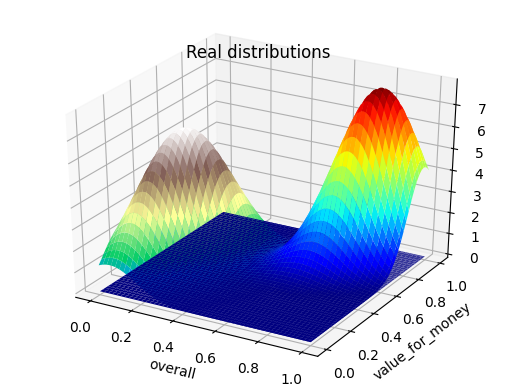

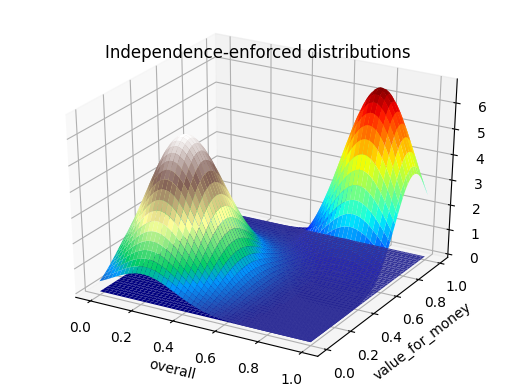

In [19]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Here we are plotting two distributions

limits = {
    'x': [0, 1],
    'y': [0, 1]
}
colors = {
    0: cm.terrain,
    1: cm.jet
}

# The first is the real one, with the correct values of covariance.
plt.figure()
for rec in [0,1]:
    plot_gaussian_3D(m[rec], c[rec], xlim=limits['x'], ylim=limits['y'],
                     xlabel=f1_name, ylabel=f2_name, title='Real distributions', cmap=colors[rec])
plt.show()

# The second is the one used by the Naive-Bayes classifier, which assumes that
# the covariances are 0 as the features are supposed independent
plt.figure()
for rec in [0,1]:
    plot_gaussian_3D(m[rec], v[rec], xlim=limits['x'], ylim=limits['y'],
                     xlabel=f1_name, ylabel=f2_name, title='Independence-enforced distributions',
                     cmap=colors[rec])
plt.show()

#### 2.2.1.2 Fit

In [ ]:
from sklearn.model_selection import train_test_split

XX_train, XX_test, YY_train, YY_test = train_test_split(XX, YY, test_size=0.3)

GNB_fit_and_predict(XX_train, XX_test, YY_train, YY_test);

Performances...

Confusion matrix:
[[11829   306]
 [  216 11522]]


Classifier performance metrics:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98     12135
         1.0       0.97      0.98      0.98     11738

    accuracy                           0.98     23873
   macro avg       0.98      0.98      0.98     23873
weighted avg       0.98      0.98      0.98     23873

final performance:  97.81%


### 2.2.2 Real DataSet

#### 2.2.2.1 Fit on real data


Fit only with overall and value_for_money

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Fit with only two features
X_real = pd.concat([data[f1_name], data[f2_name]], axis=1)
Y_real = data['recommended']

# Split the real dataset
XX_train, XX_test, YY_train, YY_test = train_test_split(X_real, Y_real, test_size=0.3)

GNB_fit_and_predict(XX_train, XX_test, YY_train, YY_test);

Performances...

Confusion matrix:
[[11455   541]
 [  499 11378]]


Classifier performance metrics:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     11996
           1       0.95      0.96      0.96     11877

    accuracy                           0.96     23873
   macro avg       0.96      0.96      0.96     23873
weighted avg       0.96      0.96      0.96     23873

final performance:  95.64%


Fit with all features (one-by-one)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import numpy as np

# Now we fit the Naive Bayes classifier using one feature per time.
# So we select only one feature, then we train the classifier and append the
# final result to a list
res = []
for feature in features:
    X_real = pd.concat([data[feature]], axis=1)
    Y_real = data['recommended']
    
    # Split the real dataset
    XX_train, XX_test, YY_train, YY_test = train_test_split(X_real, Y_real, test_size=0.3)

    res.append(GNB_fit_and_predict(XX_train, XX_test, YY_train, YY_test, verbose=False))

# Print a pretty table
table = tabulate(np.array([[f'{r*100:.2f}%' for r in res]]), features, tablefmt="fancy_grid")
print(table)

╒═══════════╤════════════════╤═════════════════╤════════════╤═════════════════╤══════════════════╤═════════════════════╤═══════════════════╕
│ overall   │ seat_comfort   │ cabin_service   │ food_bev   │ entertainment   │ ground_service   │ wifi_connectivity   │ value_for_money   │
╞═══════════╪════════════════╪═════════════════╪════════════╪═════════════════╪══════════════════╪═════════════════════╪═══════════════════╡
│ 95.33%    │ 82.30%         │ 86.08%          │ 81.62%     │ 77.03%          │ 84.48%           │ 73.90%              │ 91.01%            │
╘═══════════╧════════════════╧═════════════════╧════════════╧═════════════════╧══════════════════╧═════════════════════╧═══════════════════╛


Fit with all possible couples of features

In [ ]:
from itertools import combinations
import pandas as pd
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import numpy as np

res = []
# Now we calculate all the possible couples of features, then we train the classifier with each of
# them and append the final result to a list
for (x1,x2) in combinations(features, 2):
    X_real = pd.concat([data[x1], data[x2]], axis=1)
    Y_real = data['recommended']

    # Split the real dataset
    XX_train, XX_test, YY_train, YY_test = train_test_split(X_real, Y_real, test_size=0.3)

    res.append(GNB_fit_and_predict(XX_train, XX_test, YY_train, YY_test, verbose=False))

# Print a pretty table
table = tabulate(np.array([[f'{r*100:.2f}%' for r in res]]),
                 [f"{x1} + {x2}" for (x1,x2) in combinations(features, 2)],
                 tablefmt="fancy_grid")
print(table)

╒══════════════════════════╤═══════════════════════════╤══════════════════════╤═══════════════════════════╤════════════════════════════╤═══════════════════════════════╤═════════════════════════════╤════════════════════════════════╤═══════════════════════════╤════════════════════════════════╤═════════════════════════════════╤════════════════════════════════════╤══════════════════════════════════╤════════════════════════════╤═════════════════════════════════╤══════════════════════════════════╤═════════════════════════════════════╤═══════════════════════════════════╤════════════════════════════╤═════════════════════════════╤════════════════════════════════╤══════════════════════════════╤══════════════════════════════════╤═════════════════════════════════════╤═══════════════════════════════════╤══════════════════════════════════════╤════════════════════════════════════╤═══════════════════════════════════════╕
│ overall + seat_comfort   │ overall + cabin_service   │ overall + food_bev   │ o

Fit with all features together

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Here we perform a complete fit, using all features
X_real = pd.concat([data[feature] for feature in features], axis=1)
Y_real = data['recommended']

# Split the real dataset
XX_train, XX_test, YY_train, YY_test = train_test_split(X_real, Y_real, test_size=0.3)

GNB_fit_and_predict(XX_train, XX_test, YY_train, YY_test);

Performances...

Confusion matrix:
[[11521   562]
 [  575 11215]]


Classifier performance metrics:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     12083
           1       0.95      0.95      0.95     11790

    accuracy                           0.95     23873
   macro avg       0.95      0.95      0.95     23873
weighted avg       0.95      0.95      0.95     23873

final performance:  95.24%


## 2.3 KNN

### Spark functions

In [ ]:
from math import sqrt
import numpy as np
import heapq

def euclidean_distance(yx_train):
    """This function is used by Spark to calculate the euclidean distance between 
    the test value in broadcast and the one passed as parameter. 
    This function is called when the cluster is finding the K-NNs
    in each partition"""
    global x_test_br
    x_train = yx_train[1:]  # the first column of yx_train is the label
    distance = 0.0
    for i in range(len(x_train)):
        distance += (x_train[i] - x_test_br.value[i])**2
    return sqrt(distance)

def K_nearest_neighbors(collection):
    """This function is used by Spark to get the K point with 
    the minimum euclidean distance with respect to a given point."""
    global K_br
    return np.array(heapq.nsmallest(K_br.value, collection, euclidean_distance))

In [ ]:
import numpy as np
from operator import add


K_br = None
x_test_br = None


def KNN_fit_spark(K, XX_train, XX_test, YY_train):
    # create whole dataset
    YY__XX_train = np.column_stack((YY_train, XX_train))
    
    # parallelize the dataset
    rdd = sc.parallelize(YY__XX_train).cache()

    # broadcast K
    global K_br
    K_br = sc.broadcast(K)

    # YY_estimated will contain the estimated class for each x_test
    YY_estimated = []
    for x_test in XX_test:
        # broadcast each test value
        global x_test_br
        x_test_br = sc.broadcast(x_test)

        # find the K nearest neighbors with respect to x_test_br
        KNN = K_nearest_neighbors(rdd.mapPartitions(K_nearest_neighbors).collect())

        # parallelize all the neighbors label
        KNN_rdd = sc.parallelize(KNN[:,0]).cache()

        # compute the number of ones in the partitions
        total_ones = KNN_rdd.reduce(add)

        # the estimated label is the most common value in KNN's labels
        YY_estimated.append(int(total_ones > K/2))

    return np.array(YY_estimated)

### Fit function

In [ ]:
from sklearn import neighbors
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


def KNN_fit_and_predict(K, XX_train, XX_test, XX_val, YY_train, YY_test, YY_val,
                        use_spark=False, plot_flag=False, verbose=True):
    """Fits the KNN classifier, using K neighbors. If the use_spark flag is set 
    to True, then the classification is performed using the Spark 
    implementation too.
    Returns the performances and the MSE of the KNN implemented in sklearn. 
    Raises exception if the estimations of the two classifiers (sklearn and Spark) are different."""

    # we create an instance of Neighbours Classifier and fit the data.
    knn = neighbors.KNeighborsClassifier(K, weights='uniform')
    YY_estimated = knn.fit(XX_train, YY_train).predict(XX_val)
    performance = knn.score(XX_test, YY_test)

    # try with spark...
    if use_spark:
        YY_estimated_spark = KNN_fit_spark(K, XX_train, XX_val, YY_train)
        if not np.array_equal(YY_estimated, YY_estimated_spark):
            raise Exception("Bad implementaion of KNN with Spark!")

    if plot_flag:
        # Create color maps
        cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
        cmap_bold  = ListedColormap(['#FF0000', '#0000FF'])

        # init vars
        h = .02 # step size in the mesh
        
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        x_min, x_max = XX[:, 0].min() - 1, XX[:, 0].max() + 1
        y_min, y_max = XX[:, 1].min() - 1, XX[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        fig = plt.figure()
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

        # Plot also the training points
        plt.scatter(XX_train[:, 0], XX_train[:, 1], c=YY_train, cmap=cmap_bold, edgecolor='k', s=20)   
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title(f"0/1 outcome classification (K={K})")
        plt.show()

    if verbose:
        print_fit_performance(YY_test, YY_estimated)
        print(f"final performance: {performance * 100: .2f}%")

    return performance, mean_squared_error(YY_val, YY_estimated)


def KNN_tuning(XX, YY, maxK=1000, nk=31, n_plot_steps=None,
               use_spark=False, best_K_plot_flag=False, verbose=1):
    """Finds the best K parameter, trying with nk different values less than maxK.
    Plots the decision regions each n_plot_steps K values."""

    # MSEs dictionary for each K
    mses = {}
    # Performance dictionary for each K
    perf = {}

    # KK will be distributed as a parabolic curve f such that f(0)=1 and f(nk-1)=maxK
    KK = parabolic_curve(nk, a=(maxK-1)/(nk - 1)**2, b=0, c=1)

    if verbose == 2:
        print(f'Trying for K={KK}')

    # split data into training, test and validation set
    XX_train, XX_test, XX_val, YY_train, YY_test, YY_val = train_test_val_split(XX, YY, 0.3, 0.2)

    for i in range(len(KK)):
        K = KK[i]

        plot_flag = (i%n_plot_steps==0) if n_plot_steps is not None else False
        perf[K], mses[K] = KNN_fit_and_predict(K, XX_train, XX_test, XX_val,
                                               YY_train, YY_test, YY_val,
                                               use_spark=use_spark,
                                               plot_flag=plot_flag, verbose=False)
        
        if verbose == 2:
            print(f"K = {K}, MSE = {mses[K]: .4}")

    best_K = min(mses, key=mses.get)
    best_mse = mses[best_K]
    best_perf = perf[best_K]
    
    if best_K_plot_flag:
        plt.figure()
        plt.plot(KK, list(mses.values()))
        plt.xlabel('K')
        plt.ylabel('Test error')
        plt.title("Performance")      
        r = (min(mses.values()), max(list(mses.values())))
        plt.annotate(f'{best_mse:.3} for K={best_K}', xy=(best_K, best_mse),
                    xytext=(0.4*max(KK), r[0] + 0.4*(r[1]- r[0])),
                    arrowprops=dict(facecolor='black', headwidth=10, shrink=0.1))
        plt.show()

    if verbose:
        print(f"Final performance: {best_perf * 100: .2f}%")

    return best_K, best_mse, best_perf

### 2.3.1 Synthetic DataSet

#### 2.3.1.1 Data visualization

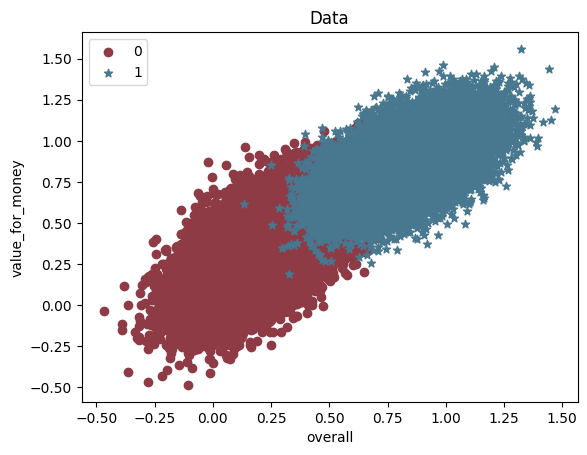

In [ ]:
import matplotlib.pyplot as plt

# Plot the synthetic dataset in order to visualize it

color = {
    0: '#8e3b46',
    1: '#477890'
}
marker = {
    0: 'o',
    1: '*'
}

plt.figure()
plt.title('Data')
for rec in [0,1]:
    plt.scatter(X[rec][:, 0], X[rec][:, 1], color=color[rec], marker=marker[rec], label=str(rec))
plt.xlabel(f1_name)
plt.ylabel(f2_name)
plt.legend()
plt.show()

#### 2.3.1.2 Fit

Trying for K=[1, 3, 9, 19, 34, 53, 75, 103, 134, 169, 209, 252, 300, 352, 409, 469, 534, 602, 675, 752, 833, 919, 1008, 1102, 1200, 1302, 1408, 1518, 1633, 1752, 1874, 2001, 2133, 2268, 2407, 2551, 2699, 2851, 3007, 3167, 3332, 3500, 3673, 3850, 4031, 4217, 4406, 4600, 4798, 5000]


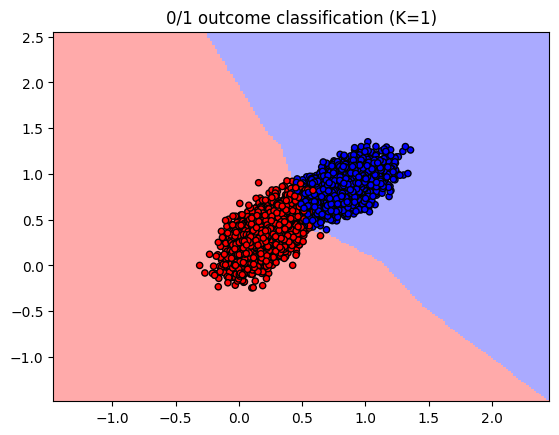

K = 1, MSE =  0.0265
K = 3, MSE =  0.025
K = 9, MSE =  0.0225


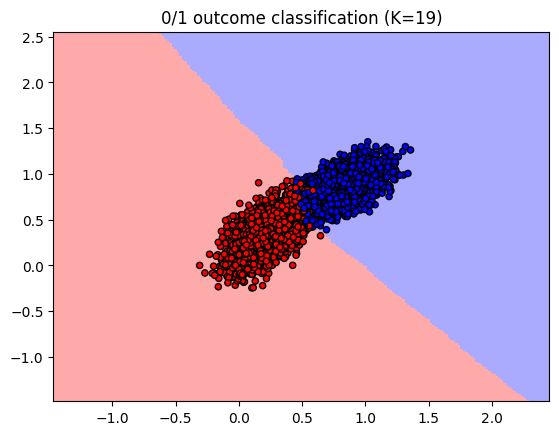

K = 19, MSE =  0.0245
K = 34, MSE =  0.0245
K = 53, MSE =  0.0255


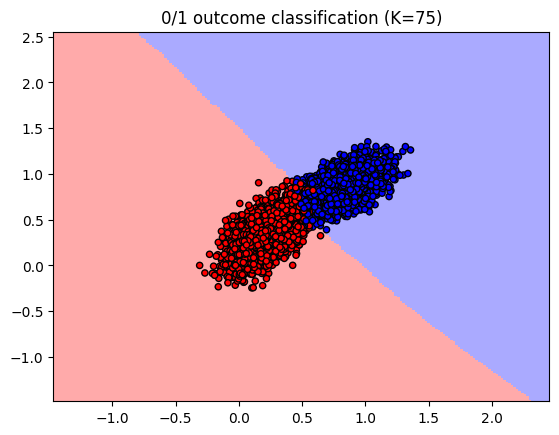

K = 75, MSE =  0.0245
K = 103, MSE =  0.0245
K = 134, MSE =  0.025


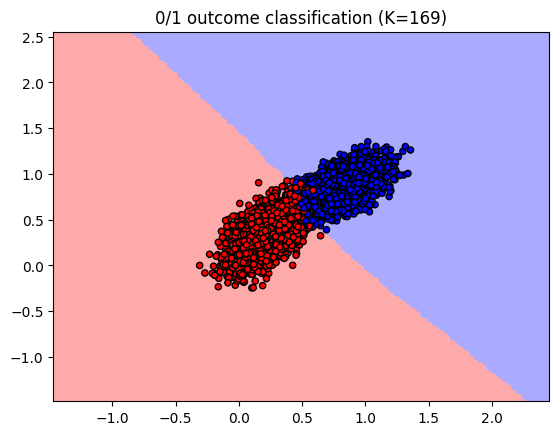

K = 169, MSE =  0.0255
K = 209, MSE =  0.026
K = 252, MSE =  0.0265


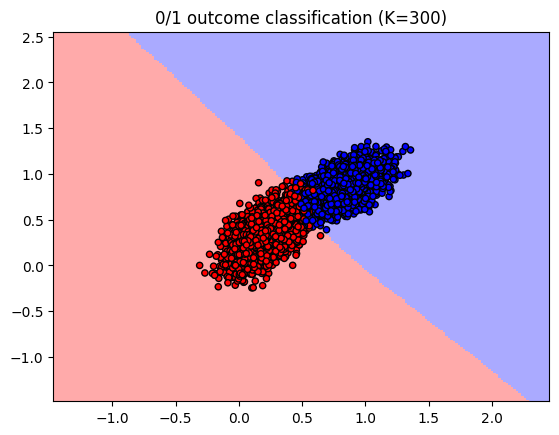

K = 300, MSE =  0.027
K = 352, MSE =  0.0255
K = 409, MSE =  0.0255


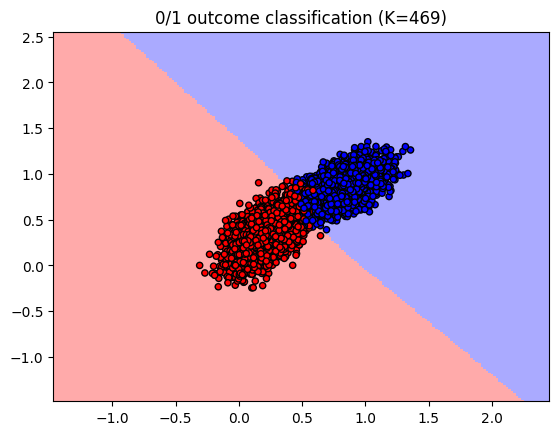

K = 469, MSE =  0.026
K = 534, MSE =  0.026
K = 602, MSE =  0.0265


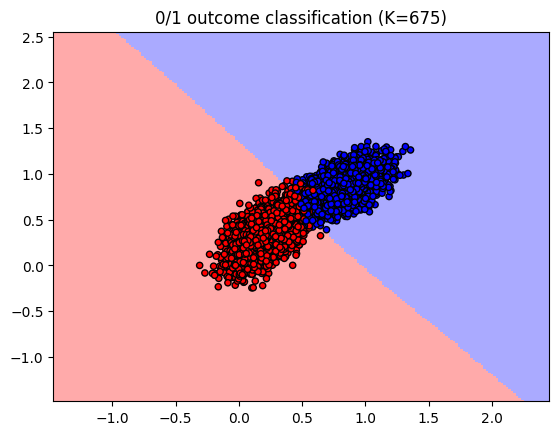

K = 675, MSE =  0.0265
K = 752, MSE =  0.027
K = 833, MSE =  0.026


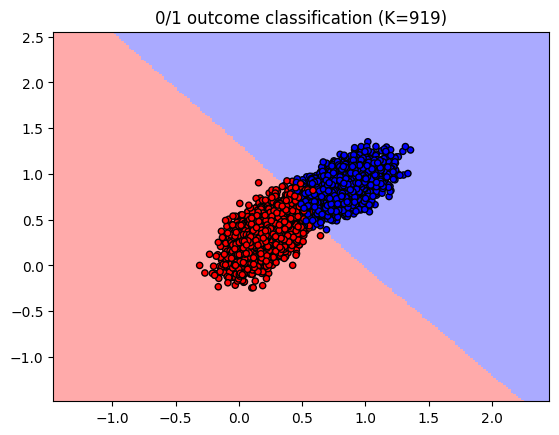

K = 919, MSE =  0.026
K = 1008, MSE =  0.0265
K = 1102, MSE =  0.0265


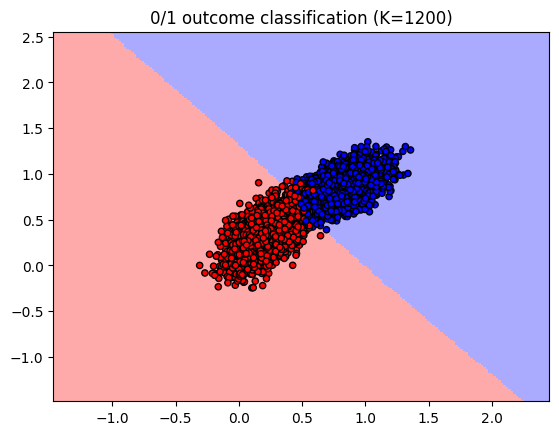

K = 1200, MSE =  0.027
K = 1302, MSE =  0.027
K = 1408, MSE =  0.028


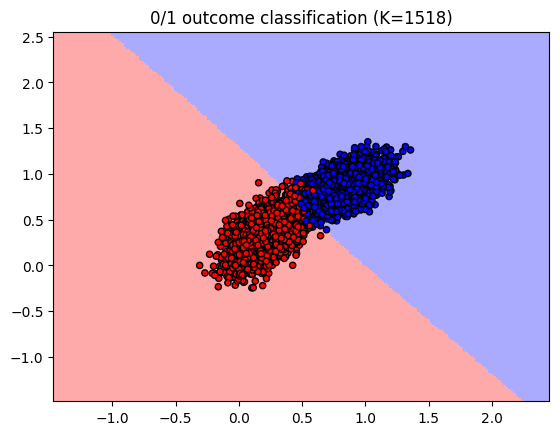

K = 1518, MSE =  0.0285
K = 1633, MSE =  0.029
K = 1752, MSE =  0.029


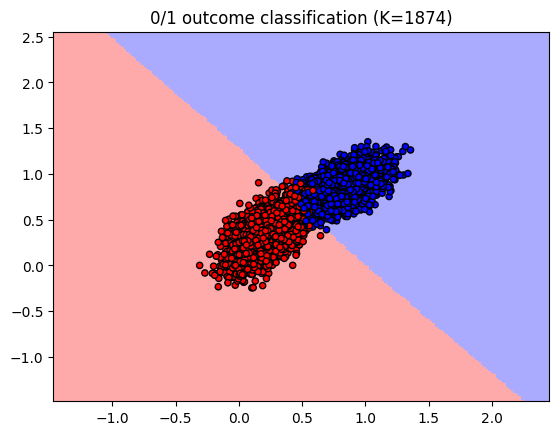

K = 1874, MSE =  0.029
K = 2001, MSE =  0.029
K = 2133, MSE =  0.029


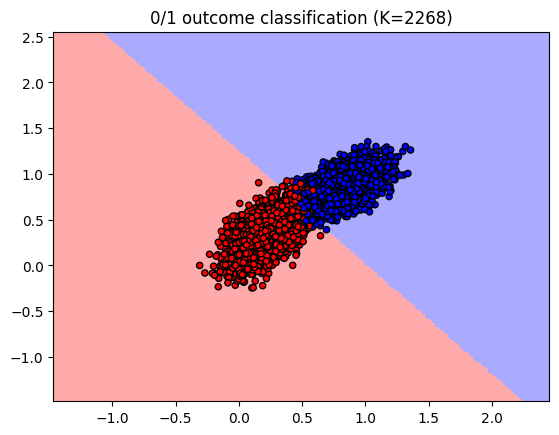

K = 2268, MSE =  0.0285
K = 2407, MSE =  0.029
K = 2551, MSE =  0.029


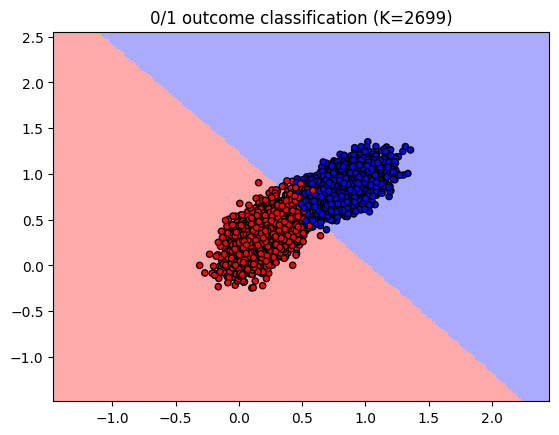

K = 2699, MSE =  0.029
K = 2851, MSE =  0.0285
K = 3007, MSE =  0.0285


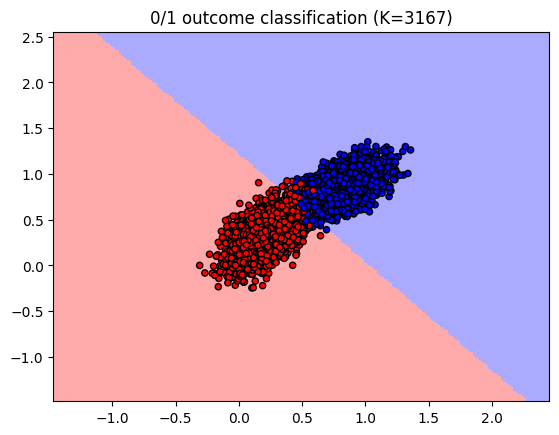

K = 3167, MSE =  0.0285
K = 3332, MSE =  0.0285
K = 3500, MSE =  0.0285


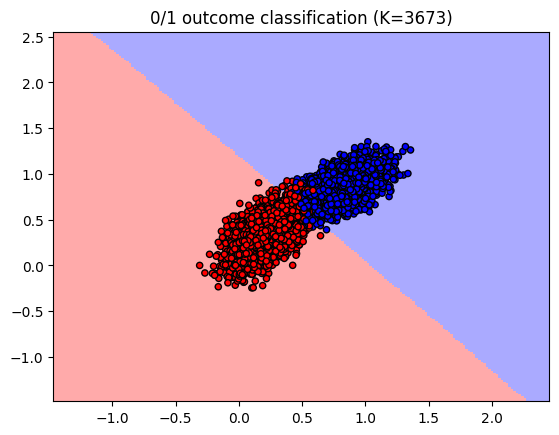

K = 3673, MSE =  0.0285
K = 3850, MSE =  0.0295
K = 4031, MSE =  0.029


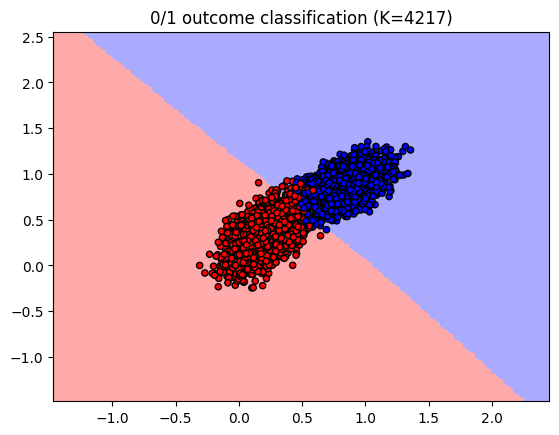

K = 4217, MSE =  0.03
K = 4406, MSE =  0.03
K = 4600, MSE =  0.0315


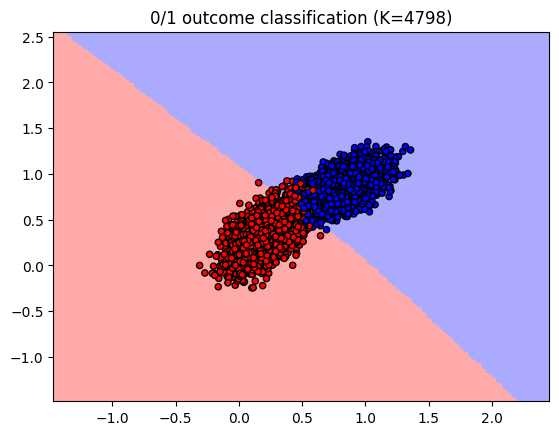

K = 4798, MSE =  0.036
K = 5000, MSE =  0.513


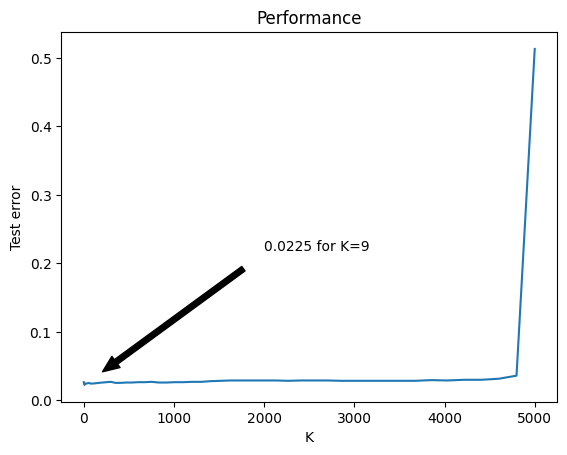

Final performance:  97.60%


In [ ]:
N_sample = 10_000

# Fitting the KNN classifier on the syntetic dataset.
# Only a subset of the whole dataset is used due to time reasons, as
# the results are compared with the ones produced by our custom
# classifier with Spark
KNN_tuning(XX[:N_sample], YY[:N_sample], maxK=1_000, nk=50,
           n_plot_steps=3, use_spark=True, best_K_plot_flag=True, verbose=2);

### 2.3.2 Real DataSet

#### 2.3.2.1 Fit on real data

Fit only with overall and value_for_money

Trying for K=[1, 2, 3, 4, 5, 6, 8, 10, 14, 17, 21, 25, 30, 35, 40, 46, 53, 59, 67, 74, 82, 90, 99, 108, 118, 128, 138, 149, 160, 172, 184, 197, 209, 223, 236, 250, 265, 280, 295, 311, 327, 343, 360, 378, 395, 414, 432, 451, 470, 490, 510, 531, 552, 573, 595, 617, 640, 663, 687, 710, 735, 759, 785, 810, 836, 862, 889, 916, 944, 972, 1000, 1029, 1058, 1087, 1117, 1148, 1179, 1210, 1241, 1273, 1306, 1339, 1372, 1406, 1440, 1474, 1509, 1544, 1580, 1616, 1653, 1689, 1727, 1765, 1803, 1841, 1880, 1920, 1959, 2000]
K = 1, MSE =  0.04499
K = 2, MSE =  0.05447
K = 3, MSE =  0.0448
K = 4, MSE =  0.05805
K = 5, MSE =  0.04329
K = 6, MSE =  0.04379
K = 8, MSE =  0.04379
K = 10, MSE =  0.04329
K = 14, MSE =  0.04379
K = 17, MSE =  0.04436
K = 21, MSE =  0.04436
K = 25, MSE =  0.04436
K = 30, MSE =  0.04379
K = 35, MSE =  0.04335
K = 40, MSE =  0.0443
K = 46, MSE =  0.04379
K = 53, MSE =  0.04379
K = 59, MSE =  0.04379
K = 67, MSE =  0.04335
K = 74, MSE =  0.04379
K = 82, MSE =  0.04285
K = 90, MSE 

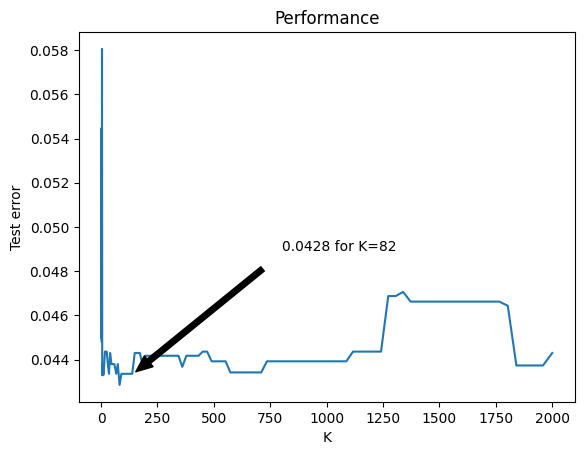

Final performance:  95.40%


In [ ]:
import pandas as pd

# Fit with only two features
X_real = pd.concat([data[f1_name], data[f2_name]], axis=1)
Y_real = data['recommended']

# Tuning the K value
KNN_tuning(X_real.values, Y_real.values, maxK=2_000, nk=100,
           best_K_plot_flag=True, verbose=2);

Fit with all features (one-by-one)

***
 Fitting with 'overall' feature
Trying for K=[1, 2, 3, 4, 5, 6, 8, 10, 14, 17, 21, 25, 30, 35, 40, 46, 53, 59, 67, 74, 82, 90, 99, 108, 118, 128, 138, 149, 160, 172, 184, 197, 209, 223, 236, 250, 265, 280, 295, 311, 327, 343, 360, 378, 395, 414, 432, 451, 470, 490, 510, 531, 552, 573, 595, 617, 640, 663, 687, 710, 735, 759, 785, 810, 836, 862, 889, 916, 944, 972, 1000, 1029, 1058, 1087, 1117, 1148, 1179, 1210, 1241, 1273, 1306, 1339, 1372, 1406, 1440, 1474, 1509, 1544, 1580, 1616, 1653, 1689, 1727, 1765, 1803, 1841, 1880, 1920, 1959, 2000]
K = 1, MSE =  0.04354
K = 2, MSE =  0.04354
K = 3, MSE =  0.04354
K = 4, MSE =  0.04354
K = 5, MSE =  0.06264
K = 6, MSE =  0.08055
K = 8, MSE =  0.06145
K = 10, MSE =  0.06145
K = 14, MSE =  0.06145
K = 17, MSE =  0.08055
K = 21, MSE =  0.06145
K = 25, MSE =  0.06145
K = 30, MSE =  0.06145
K = 35, MSE =  0.06145
K = 40, MSE =  0.04354
K = 46, MSE =  0.04354
K = 53, MSE =  0.04354
K = 59, MSE =  0.04354
K = 67, MSE =  0.04354
K = 74, MSE =  0.043

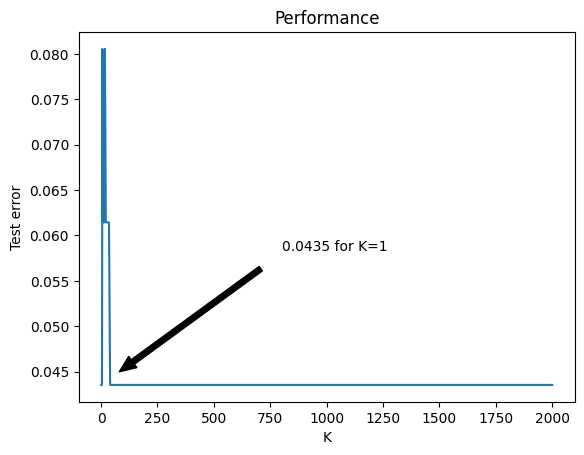

Final performance:  95.46%
***
 Fitting with 'seat_comfort' feature
Trying for K=[1, 2, 3, 4, 5, 6, 8, 10, 14, 17, 21, 25, 30, 35, 40, 46, 53, 59, 67, 74, 82, 90, 99, 108, 118, 128, 138, 149, 160, 172, 184, 197, 209, 223, 236, 250, 265, 280, 295, 311, 327, 343, 360, 378, 395, 414, 432, 451, 470, 490, 510, 531, 552, 573, 595, 617, 640, 663, 687, 710, 735, 759, 785, 810, 836, 862, 889, 916, 944, 972, 1000, 1029, 1058, 1087, 1117, 1148, 1179, 1210, 1241, 1273, 1306, 1339, 1372, 1406, 1440, 1474, 1509, 1544, 1580, 1616, 1653, 1689, 1727, 1765, 1803, 1841, 1880, 1920, 1959, 2000]
K = 1, MSE =  0.1796
K = 2, MSE =  0.1796
K = 3, MSE =  0.1796
K = 4, MSE =  0.1796
K = 5, MSE =  0.1796
K = 6, MSE =  0.1796
K = 8, MSE =  0.2012
K = 10, MSE =  0.2012
K = 14, MSE =  0.2012
K = 17, MSE =  0.2012
K = 21, MSE =  0.2012
K = 25, MSE =  0.1796
K = 30, MSE =  0.1796
K = 35, MSE =  0.1796
K = 40, MSE =  0.1796
K = 46, MSE =  0.1796
K = 53, MSE =  0.1796
K = 59, MSE =  0.1796
K = 67, MSE =  0.1796
K = 74,

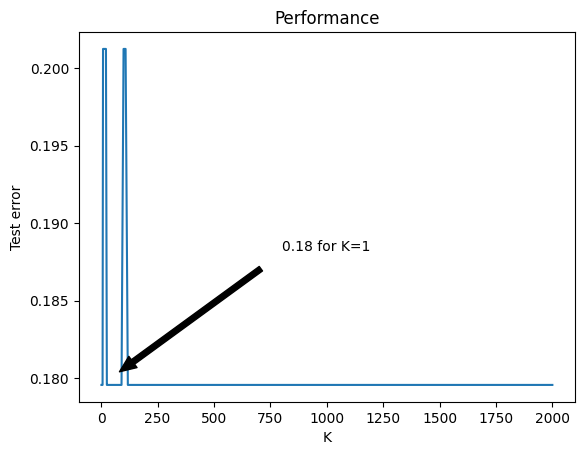

Final performance:  82.19%
***
 Fitting with 'cabin_service' feature
Trying for K=[1, 2, 3, 4, 5, 6, 8, 10, 14, 17, 21, 25, 30, 35, 40, 46, 53, 59, 67, 74, 82, 90, 99, 108, 118, 128, 138, 149, 160, 172, 184, 197, 209, 223, 236, 250, 265, 280, 295, 311, 327, 343, 360, 378, 395, 414, 432, 451, 470, 490, 510, 531, 552, 573, 595, 617, 640, 663, 687, 710, 735, 759, 785, 810, 836, 862, 889, 916, 944, 972, 1000, 1029, 1058, 1087, 1117, 1148, 1179, 1210, 1241, 1273, 1306, 1339, 1372, 1406, 1440, 1474, 1509, 1544, 1580, 1616, 1653, 1689, 1727, 1765, 1803, 1841, 1880, 1920, 1959, 2000]
K = 1, MSE =  0.2347
K = 2, MSE =  0.2347
K = 3, MSE =  0.1407
K = 4, MSE =  0.1407
K = 5, MSE =  0.1407
K = 6, MSE =  0.1407
K = 8, MSE =  0.1407
K = 10, MSE =  0.1407
K = 14, MSE =  0.1407
K = 17, MSE =  0.1407
K = 21, MSE =  0.1407
K = 25, MSE =  0.1407
K = 30, MSE =  0.1407
K = 35, MSE =  0.1407
K = 40, MSE =  0.1407
K = 46, MSE =  0.1407
K = 53, MSE =  0.1407
K = 59, MSE =  0.1407
K = 67, MSE =  0.1407
K = 74

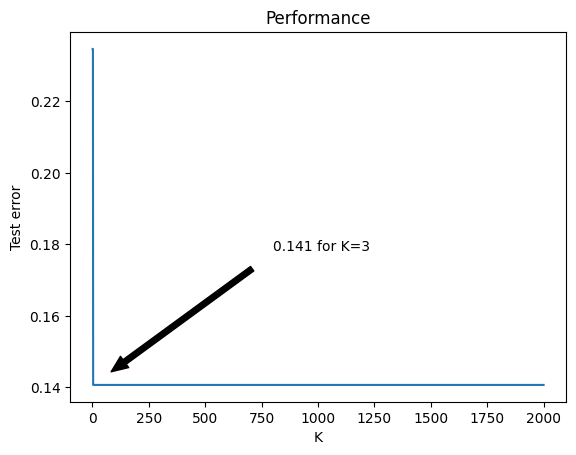

Final performance:  85.74%
***
 Fitting with 'food_bev' feature
Trying for K=[1, 2, 3, 4, 5, 6, 8, 10, 14, 17, 21, 25, 30, 35, 40, 46, 53, 59, 67, 74, 82, 90, 99, 108, 118, 128, 138, 149, 160, 172, 184, 197, 209, 223, 236, 250, 265, 280, 295, 311, 327, 343, 360, 378, 395, 414, 432, 451, 470, 490, 510, 531, 552, 573, 595, 617, 640, 663, 687, 710, 735, 759, 785, 810, 836, 862, 889, 916, 944, 972, 1000, 1029, 1058, 1087, 1117, 1148, 1179, 1210, 1241, 1273, 1306, 1339, 1372, 1406, 1440, 1474, 1509, 1544, 1580, 1616, 1653, 1689, 1727, 1765, 1803, 1841, 1880, 1920, 1959, 2000]
K = 1, MSE =  0.1927
K = 2, MSE =  0.1927
K = 3, MSE =  0.1809
K = 4, MSE =  0.1809
K = 5, MSE =  0.1809
K = 6, MSE =  0.1809
K = 8, MSE =  0.1809
K = 10, MSE =  0.1809
K = 14, MSE =  0.1927
K = 17, MSE =  0.1809
K = 21, MSE =  0.1927
K = 25, MSE =  0.1809
K = 30, MSE =  0.1809
K = 35, MSE =  0.1809
K = 40, MSE =  0.1809
K = 46, MSE =  0.1809
K = 53, MSE =  0.1809
K = 59, MSE =  0.1927
K = 67, MSE =  0.1927
K = 74, MSE

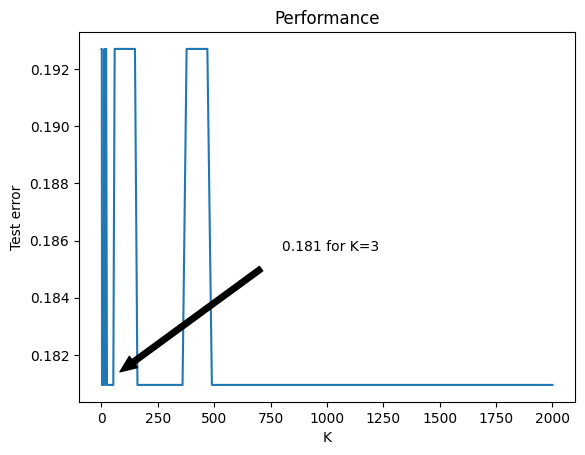

Final performance:  82.05%
***
 Fitting with 'entertainment' feature
Trying for K=[1, 2, 3, 4, 5, 6, 8, 10, 14, 17, 21, 25, 30, 35, 40, 46, 53, 59, 67, 74, 82, 90, 99, 108, 118, 128, 138, 149, 160, 172, 184, 197, 209, 223, 236, 250, 265, 280, 295, 311, 327, 343, 360, 378, 395, 414, 432, 451, 470, 490, 510, 531, 552, 573, 595, 617, 640, 663, 687, 710, 735, 759, 785, 810, 836, 862, 889, 916, 944, 972, 1000, 1029, 1058, 1087, 1117, 1148, 1179, 1210, 1241, 1273, 1306, 1339, 1372, 1406, 1440, 1474, 1509, 1544, 1580, 1616, 1653, 1689, 1727, 1765, 1803, 1841, 1880, 1920, 1959, 2000]
K = 1, MSE =  0.223
K = 2, MSE =  0.223
K = 3, MSE =  0.223
K = 4, MSE =  0.223
K = 5, MSE =  0.223
K = 6, MSE =  0.223
K = 8, MSE =  0.223
K = 10, MSE =  0.223
K = 14, MSE =  0.223
K = 17, MSE =  0.223
K = 21, MSE =  0.223
K = 25, MSE =  0.223
K = 30, MSE =  0.223
K = 35, MSE =  0.223
K = 40, MSE =  0.223
K = 46, MSE =  0.223
K = 53, MSE =  0.223
K = 59, MSE =  0.223
K = 67, MSE =  0.223
K = 74, MSE =  0.223
K = 

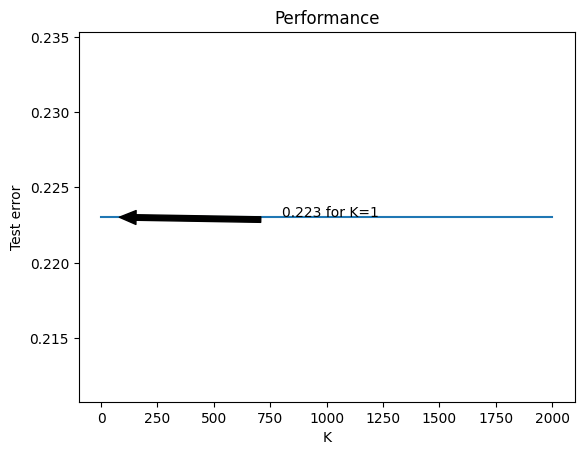

Final performance:  77.34%
***
 Fitting with 'ground_service' feature
Trying for K=[1, 2, 3, 4, 5, 6, 8, 10, 14, 17, 21, 25, 30, 35, 40, 46, 53, 59, 67, 74, 82, 90, 99, 108, 118, 128, 138, 149, 160, 172, 184, 197, 209, 223, 236, 250, 265, 280, 295, 311, 327, 343, 360, 378, 395, 414, 432, 451, 470, 490, 510, 531, 552, 573, 595, 617, 640, 663, 687, 710, 735, 759, 785, 810, 836, 862, 889, 916, 944, 972, 1000, 1029, 1058, 1087, 1117, 1148, 1179, 1210, 1241, 1273, 1306, 1339, 1372, 1406, 1440, 1474, 1509, 1544, 1580, 1616, 1653, 1689, 1727, 1765, 1803, 1841, 1880, 1920, 1959, 2000]
K = 1, MSE =  0.157
K = 2, MSE =  0.157
K = 3, MSE =  0.157
K = 4, MSE =  0.1607
K = 5, MSE =  0.2105
K = 6, MSE =  0.2105
K = 8, MSE =  0.157
K = 10, MSE =  0.1607
K = 14, MSE =  0.157
K = 17, MSE =  0.157
K = 21, MSE =  0.157
K = 25, MSE =  0.157
K = 30, MSE =  0.1607
K = 35, MSE =  0.1607
K = 40, MSE =  0.1607
K = 46, MSE =  0.1607
K = 53, MSE =  0.1607
K = 59, MSE =  0.1607
K = 67, MSE =  0.1607
K = 74, MSE =

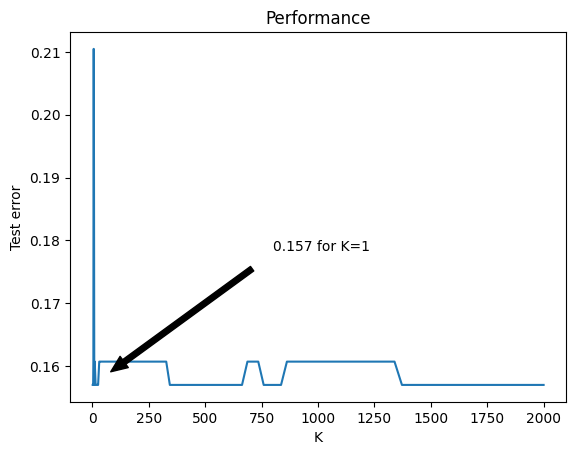

Final performance:  84.27%
***
 Fitting with 'wifi_connectivity' feature
Trying for K=[1, 2, 3, 4, 5, 6, 8, 10, 14, 17, 21, 25, 30, 35, 40, 46, 53, 59, 67, 74, 82, 90, 99, 108, 118, 128, 138, 149, 160, 172, 184, 197, 209, 223, 236, 250, 265, 280, 295, 311, 327, 343, 360, 378, 395, 414, 432, 451, 470, 490, 510, 531, 552, 573, 595, 617, 640, 663, 687, 710, 735, 759, 785, 810, 836, 862, 889, 916, 944, 972, 1000, 1029, 1058, 1087, 1117, 1148, 1179, 1210, 1241, 1273, 1306, 1339, 1372, 1406, 1440, 1474, 1509, 1544, 1580, 1616, 1653, 1689, 1727, 1765, 1803, 1841, 1880, 1920, 1959, 2000]
K = 1, MSE =  0.3891
K = 2, MSE =  0.3995
K = 3, MSE =  0.3525
K = 4, MSE =  0.3995
K = 5, MSE =  0.3995
K = 6, MSE =  0.3995
K = 8, MSE =  0.3995
K = 10, MSE =  0.3044
K = 14, MSE =  0.3044
K = 17, MSE =  0.3044
K = 21, MSE =  0.3044
K = 25, MSE =  0.294
K = 30, MSE =  0.3044
K = 35, MSE =  0.3044
K = 40, MSE =  0.294
K = 46, MSE =  0.3044
K = 53, MSE =  0.294
K = 59, MSE =  0.247
K = 67, MSE =  0.2574
K = 74

In [ ]:
import pandas as pd
from tabulate import tabulate
import numpy as np

# Now we fit the KNN classifier using one feature per time.
# So we select only one feature, then we train the classifier and append the
# final result to a list

best_k = []
best_mse = []
best_score = []
for feature in features:
    X_real = pd.concat([data[feature]], axis=1)
    Y_real = data['recommended']

    print(f"***\n Fitting with '{feature}' feature")
    # Tuning the K value
    k, mse, score = KNN_tuning(X_real.values, Y_real.values, maxK=2_000, nk=100,
                              best_K_plot_flag=True, verbose=2)
    best_k.append(k)
    best_mse.append(mse)
    best_score.append(score)

# Print a pretty table
table = tabulate(np.array([['K'] + [f'{k}' for k in best_k],
                           ['MSE'] + [f'{mse*100:.2f}%' for mse in best_mse],
                           ['Score'] + [f'{score*100:.2f}%' for score in best_score]]),
                 features, tablefmt="fancy_grid")
print(table)

Fit with all features together

Trying for K=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 30, 32, 35, 37, 40, 43, 46, 49, 52, 55, 59, 62, 66, 70, 73, 77, 81, 85, 90, 94, 98, 103, 107, 112, 117, 122, 127, 132, 137, 142, 148, 153, 159, 165, 170, 176, 182, 188, 195, 201, 207, 214, 220, 227, 234, 241, 248, 255, 262, 270, 277, 284, 292, 300, 308, 316, 324, 332, 340, 348, 357, 365, 374, 383, 391, 400, 409, 419, 428, 437, 447, 456, 466, 475, 485, 495, 505, 515, 526, 536, 546, 557, 568, 578, 589, 600, 611, 622, 634, 645, 657, 668, 680, 692, 703, 715, 727, 740, 752, 764, 777, 789, 802, 815, 828, 841, 854, 867, 880, 893, 907, 920, 934, 948, 962, 976, 990, 1004, 1018, 1033, 1047, 1062, 1077, 1091, 1106, 1121, 1136, 1151, 1167, 1182, 1198, 1213, 1229, 1245, 1261, 1277, 1293, 1309, 1325, 1342, 1358, 1375, 1391, 1408, 1425, 1442, 1459, 1477, 1494, 1511, 1529, 1546, 1564, 1582, 1600, 1618, 1636, 1654, 1673, 1691, 1710, 1728, 1747, 1766, 1785, 1804, 1823, 1842, 1861, 1881, 1900, 1920, 1940,

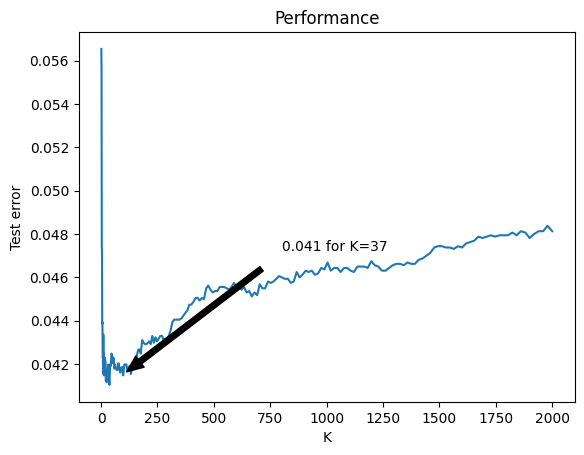

Final performance:  95.78%


In [ ]:
import pandas as pd

# Here we perform a complete fit, using all features

X_real = pd.concat([data[feature] for feature in features], axis=1)
Y_real = data['recommended']

# Tuning the K value
KNN_tuning(X_real.values, Y_real.values, maxK=2_000, nk=200,
           best_K_plot_flag=True, verbose=2);

## 2.4 Logistic Regression

### Spark functions

In [ ]:
import numpy as np
from operator import add

def sigmoid(x):
    """Sigmoid function in range ]0,1[. Returns 1/(1+e^-x)"""
    return 1 / (1 + np.exp(-x))

def compute_gradient(yx_train):
    """Returns the gradient on a single point in the training set."""
    global w_br
    x = yx_train[1:]
    y = -1 + 2 * yx_train[0]

    w_dot_x = w_br.value @ x.T
    gradient = -y * (1 - sigmoid(y * w_dot_x)) * x
    return gradient

def compute_cost(X, Y, w):
    """Returns the cost value, computed with the respect to the dataset X, the current weight w
    and the actual labels Y"""
    h = sigmoid(X @ w)
    epsilon = 1e-5
    cost = (1 / len(Y)) * (((-Y).T @ np.log(h + epsilon)) - ((1 - Y).T @ np.log(1 - h + epsilon)))
    return cost

def gradient_descent(YY__XX_train, w, learning_rate, momentum, iterations):
    """Performs the gradient descent algorithm. Returns the cost history and 
    the optimal parameters."""
    global w_br

    RDD_train = sc.parallelize(YY__XX_train).cache()

    cost_history = np.zeros((iterations,1))
    
    for i in range(iterations):     
        gradient = RDD_train.map(compute_gradient).reduce(add)
        w = w - learning_rate * (gradient/(N//2) + momentum * w)
        
        cost_history[i] = compute_cost(YY__XX_train[:, 1:],
                                       YY__XX_train[:, 0].reshape(len(YY__XX_train), 1),
                                       w.reshape(len(w), 1))
        w_br = sc.broadcast(w)

    return cost_history, w

def predict(X, w):
    """Returns the predicted label for X, given the parameter vector"""
    return np.round(sigmoid(X @ w.reshape(len(w), 1)))

In [ ]:
import numpy as np

w_br = None

def LogReg_fit_spark(XX_train, XX_test, YY_train, YY_test):
    """Fits a logistic regressor using Spark clusters, with a custom algorithm.
    Returns the predicted labels for the test set."""
    global w_br

    iterations = 2_000
    learning_rate = 0.9
    momentum = 0.05

    # Put a column of ones on the left side of XX_train and XX_test
    XX_train_ones = np.hstack((np.ones((len(XX_train),1)), XX_train))
    XX_test = np.hstack((np.ones((len(XX_test),1)), XX_test))
    YY__XX_train = np.column_stack((YY_train, XX_train_ones))

    # Initialize a vector for the parameters and broadcast it
    w = np.zeros((np.size(XX_train_ones, 1), 1)).flatten()
    w_br = sc.broadcast(w)

    # Compute the optimal parameters and save the cost history
    cost_history, w_hat = gradient_descent(YY__XX_train, w, learning_rate, momentum, iterations)

    # Plot the convergence graph of the cost function
    plt.figure()
    plt.plot(range(len(cost_history)), cost_history, 'r')
    plt.title("Convergence Graph of Cost Function")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Cost")
    plt.show()

    # Predict the test set labels and compute the score 
    y_pred = predict(XX_test, w_hat)
    score = float(sum(y_pred == YY_test))/ float(len(YY_test))
    print(f"Performance using Spark: {score:.4f}")

    # Plot the classification probability regions
    plot_sigmoid(XX_train, YY_train, w_hat, title='Data classification')

    return y_pred

### Fit function

In [ ]:
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import numpy as np

def LogReg_fit_and_predict(XX_train, XX_test, YY_train, YY_test, plot_flag=False, verbose=True):
    """Fit a logistic regression model using the sklearn library.
    Returns the performance of the model."""
    lr = SGDClassifier('log')
    YY_estimated = lr.fit(XX_train, YY_train).predict(XX_test)
    performance = lr.score(XX_test, YY_test)

    if plot_flag:
        f = plt.figure()
        plt.title('Data classification')

        # step 0: plot the training set
        plt.scatter(XX_train[:, 0], XX_train[:, 1], c=YY_train, cmap='RdBu', zorder=2)         
        # step 1: getting the boundaries of the grid
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        # step 2: creating the grid
        yy, xx = np.meshgrid(np.linspace(ylim[0], ylim[1], 30), np.linspace(xlim[0], xlim[1], 30))
        # step 3: stacking the grid
        xx_yy = np.vstack([xx.ravel(), yy.ravel()]).T
        # step 4: computing the related hyperplane values and unstacking
        pp = lr.predict_proba(xx_yy)[:, 1].reshape(xx.shape)
        # step 5: plot decision boundary and margin
        contour = ax.contourf(xx, yy, pp, 25, cmap="RdBu",
                              alpha=0.6, levels=[i/10 for i in range(11)], zorder=0)
        f.colorbar(contour)
        plt.show()
    
    if verbose:
        print_fit_performance(YY_test, YY_estimated)
        print(f"final performance: {performance * 100: .2f}%")

    return performance

### 2.4.1 Synthetic DataSet

#### 2.4.1.1 Data visualization

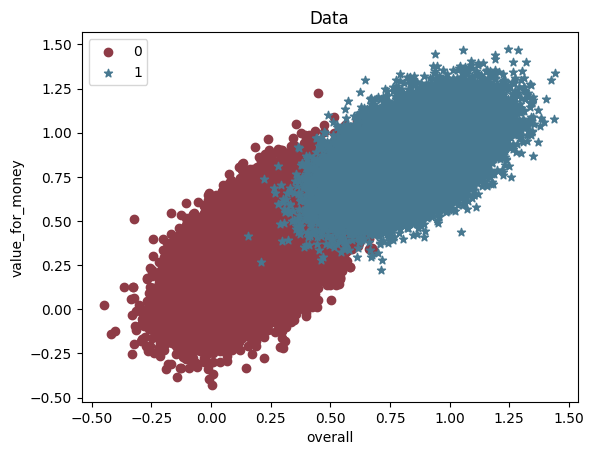

In [ ]:
import matplotlib.pyplot as plt

# Plot the synthetic dataset in order to visualize it

color = {
    0: '#8e3b46',
    1: '#477890'
}
marker = {
    0: 'o',
    1: '*'
}

plt.figure()
plt.title('Data')
for rec in [0,1]:
    plt.scatter(X[rec][:, 0], X[rec][:, 1], color=color[rec], marker=marker[rec], label=str(rec))
plt.xlabel(f1_name)
plt.ylabel(f2_name)
plt.legend()
plt.show()

#### 2.4.1.2 Fit

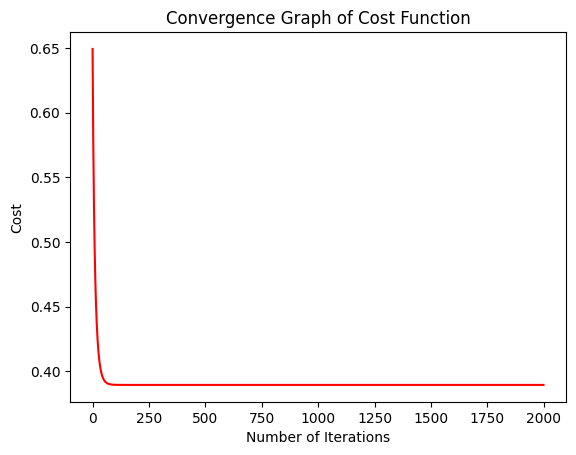

Performance using Spark: 0.9563


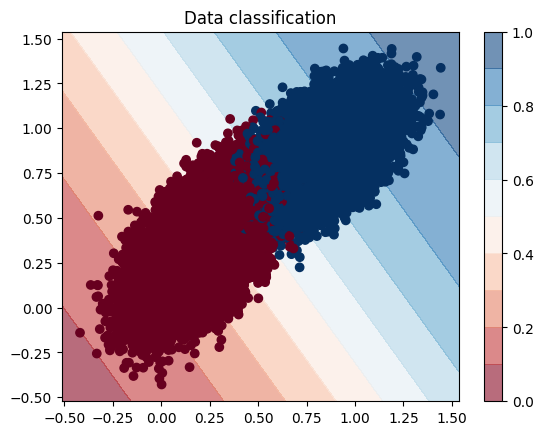

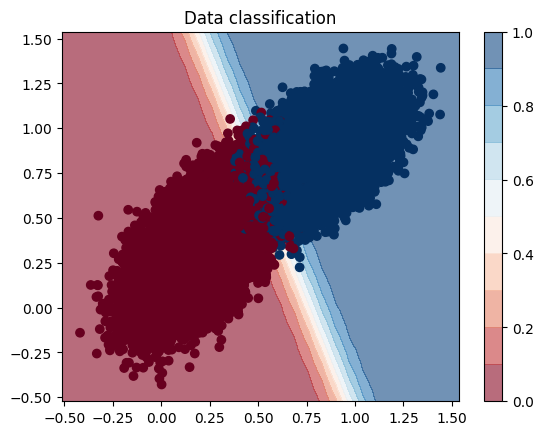

Performances...

Confusion matrix:
[[11896   222]
 [  258 11497]]


Classifier performance metrics:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     12118
         1.0       0.98      0.98      0.98     11755

    accuracy                           0.98     23873
   macro avg       0.98      0.98      0.98     23873
weighted avg       0.98      0.98      0.98     23873

final performance:  97.99%


In [ ]:
from sklearn.model_selection import train_test_split

XX_train, XX_test, YY_train, YY_test = train_test_split(XX, YY, test_size=0.3)

# Fit with both library and custom algorithms and compare the results
LogReg_fit_spark(XX_train, XX_test, YY_train, YY_test)
LogReg_fit_and_predict(XX_train, XX_test, YY_train, YY_test, True, True);

### 2.4.2 Real DataSet

Fit only with overall and value_for_money

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

X_real = pd.concat([data[f1_name], data[f2_name]], axis=1)
Y_real = data['recommended']

XX_train, XX_test, YY_train, YY_test = train_test_split(X_real, Y_real, test_size=0.3)

LogReg_fit_and_predict(XX_train, XX_test, YY_train, YY_test);

Performances...

Confusion matrix:
[[11569   522]
 [  485 11297]]


Classifier performance metrics:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     12091
           1       0.96      0.96      0.96     11782

    accuracy                           0.96     23873
   macro avg       0.96      0.96      0.96     23873
weighted avg       0.96      0.96      0.96     23873

final performance:  95.78%


Fit with all features (one-by-one)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import numpy as np

res = []
for feature in features:
    X_real = pd.concat([data[feature]], axis=1)
    Y_real = data['recommended']

    XX_train, XX_test, YY_train, YY_test = train_test_split(X_real, Y_real, test_size=0.3)

    res.append(LogReg_fit_and_predict(XX_train, XX_test, YY_train, YY_test, verbose=False))

table = tabulate(np.array([[f'{r*100:.2f}%' for r in res]]), features, tablefmt="fancy_grid")
print(table)

╒═══════════╤════════════════╤═════════════════╤════════════╤═════════════════╤══════════════════╤═════════════════════╤═══════════════════╕
│ overall   │ seat_comfort   │ cabin_service   │ food_bev   │ entertainment   │ ground_service   │ wifi_connectivity   │ value_for_money   │
╞═══════════╪════════════════╪═════════════════╪════════════╪═════════════════╪══════════════════╪═════════════════════╪═══════════════════╡
│ 95.42%    │ 82.07%         │ 86.12%          │ 82.26%     │ 77.84%          │ 84.38%           │ 73.81%              │ 91.03%            │
╘═══════════╧════════════════╧═════════════════╧════════════╧═════════════════╧══════════════════╧═════════════════════╧═══════════════════╛


Fit with all possible couples of features

In [ ]:
from itertools import combinations
import pandas as pd
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import numpy as np

res = []
for (x1,x2) in combinations(features, 2):
    X_real = pd.concat([data[x1], data[x2]], axis=1)
    Y_real = data['recommended']

    XX_train, XX_test, YY_train, YY_test = train_test_split(X_real, Y_real, test_size=0.3)

    res.append(LogReg_fit_and_predict(XX_train, XX_test, YY_train, YY_test, verbose=False))

table = tabulate(np.array([[f'{r*100:.2f}%' for r in res]]),
                 [f"{x1} + {x2}" for (x1,x2) in combinations(features, 2)],
                 tablefmt="fancy_grid")
print(table)

╒══════════════════════════╤═══════════════════════════╤══════════════════════╤═══════════════════════════╤════════════════════════════╤═══════════════════════════════╤═════════════════════════════╤════════════════════════════════╤═══════════════════════════╤════════════════════════════════╤═════════════════════════════════╤════════════════════════════════════╤══════════════════════════════════╤════════════════════════════╤═════════════════════════════════╤══════════════════════════════════╤═════════════════════════════════════╤═══════════════════════════════════╤════════════════════════════╤═════════════════════════════╤════════════════════════════════╤══════════════════════════════╤══════════════════════════════════╤═════════════════════════════════════╤═══════════════════════════════════╤══════════════════════════════════════╤════════════════════════════════════╤═══════════════════════════════════════╕
│ overall + seat_comfort   │ overall + cabin_service   │ overall + food_bev   │ o

Fit with all features together

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

X_real = pd.concat([data[feature] for feature in features], axis=1)
Y_real = data['recommended']

XX_train, XX_test, YY_train, YY_test = train_test_split(X_real, Y_real, test_size=0.3)

LogReg_fit_and_predict(XX_train, XX_test, YY_train, YY_test);

Performances...

Confusion matrix:
[[11374   502]
 [  480 11517]]


Classifier performance metrics:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     11876
           1       0.96      0.96      0.96     11997

    accuracy                           0.96     23873
   macro avg       0.96      0.96      0.96     23873
weighted avg       0.96      0.96      0.96     23873

final performance:  95.89%


## 2.5 Naive-Kernel

### Spark functions

In [ ]:
from math import sqrt
import numpy as np

def euclidean_distance(yx_train):
    """This function is used by spark to calculate the euclidean distance between 
    the value in broadcast and the one passed as parameter. 
    This function is called when the cluster is filtering the neighbour in a
    fixed range"""
    global x_test_br
    x_train = yx_train[1:] # the first column of xy_train is the label
    distance = 0.0
    for i in range(len(x_train)):
        distance += (x_train[i] - x_test_br.value[i])**2
    return sqrt(distance)

def neighbors_in_h(collection):
    """This function is used by spark to get the values that are in a fixed 
    range, computing the euclidean distance from a given point."""
    global h_br
    return np.array(list(filter(lambda x: euclidean_distance(x) <= h_br.value, collection)))

### Fit function

In [ ]:
import numpy as np
from operator import add
from random import randint
from sklearn.metrics import mean_squared_error


h_br = None
x_test_br = None


def NaiveKernel_fit_and_predict(h, XX_train, XX_test, XX_val, YY_train, YY_test, YY_val):
    # create whole dataset
    YY__XX_train = np.column_stack((YY_train, XX_train))
    
    # parallelize the dataset
    rdd = sc.parallelize(YY__XX_train).cache()

    # broadcast K
    global h_br
    h_br = sc.broadcast(h)

    # YY_estimated will contain the estimated class for each x_test
    YY_estimated = []
    for x_test in XX_test:
        # broadcast each test value
        global x_test_br
        x_test_br = sc.broadcast(x_test)

        # find the neighbors wrt x_test_br
        neighbors = rdd.mapPartitions(neighbors_in_h).collect()
        labels = [x[0] for x in neighbors]

        if len(labels) > 0:
            # parallelize all the neighbors label
            neighbors_rdd = sc.parallelize(labels).cache()

            # compute the number of ones in the partitions
            total_ones = neighbors_rdd.reduce(add)

            # the estimated label is the most common value in neighbors' labels
            YY_estimated.append(int(total_ones > len(neighbors)/2))
        else:
            YY_estimated.append(randint(0,1))

    YY_estimated = np.array(YY_estimated)
    YY_test = YY_test.flatten()
    score = sum(YY_estimated == YY_test) / len(YY_test)

    YY_estimated = []
    for x_test in XX_val:
        # broadcast each test value
        x_test_br = sc.broadcast(x_test)

        # find the neighbors wrt x_test_br
        neighbors = rdd.mapPartitions(neighbors_in_h).collect()
        labels = [x[0] for x in neighbors]

        if len(labels) > 0:
            # parallelize all the neighbors label
            neighbors_rdd = sc.parallelize(labels).cache()

            # compute the number of ones in the partitions
            total_ones = neighbors_rdd.reduce(add)

            # the estimated label is the most common value in neighbors' labels
            YY_estimated.append(int(total_ones > len(neighbors)/2))
        else:
            YY_estimated.append(randint(0,1))

    return score, mean_squared_error(YY_val, np.array(YY_estimated))


def NaiveKernel_tuning(XX, YY, minh=0.2, maxh=0.5, nh=10, test_size=0.3, val_size=0.2,
                       best_h_plot_flag=False, verbose=1):
    # split data into training, test and validation set
    XX_train, XX_test, XX_val, YY_train, YY_test, YY_val = train_test_val_split(XX, YY, test_size, val_size)
    
    # MSEs dictionary for each K
    mses = {}
    perf = {}

    # Parabolic curve f such that f(0)=minh and f(nk-1)=maxh
    hh = parabolic_curve_float(nh, a=(maxh - minh) / (nh - 1)**2, b=0, c=minh)

    if verbose == 2:
        print(f'Trying for h={hh}')

    for i in range(len(hh)):
        h = hh[i]

        perf[h], mses[h] = NaiveKernel_fit_and_predict(h, XX_train, XX_test, XX_val,
                                                       YY_train, YY_test, YY_val)
        
        if verbose == 2:
            print(f"h = {h}, MSE = {mses[h]: .4}")

    best_h = min(mses, key=mses.get)
    best_mse = mses[best_h]
    best_perf = perf[best_h]
    
    if best_h_plot_flag:
        plt.figure()
        plt.plot(hh, list(mses.values()))
        plt.xlabel('h')
        plt.ylabel('Test error')
        plt.title("Performance")      
        r = (min(mses.values()), max(list(mses.values())))
        plt.annotate(f'{best_mse:.3} for h={best_h}', xy=(best_h, best_mse),
                    xytext=(0.4*max(hh), r[0] + 0.4*(r[1]- r[0])),
                    arrowprops=dict(facecolor='black', headwidth=10, shrink=0.1))
        plt.show()

    if verbose:
        print(f"Final performance: {best_perf * 100: .2f}%")

    return best_h, best_mse, best_perf

### 2.5.1 Synthetic DataSet

#### 2.5.1.1 Data visualization

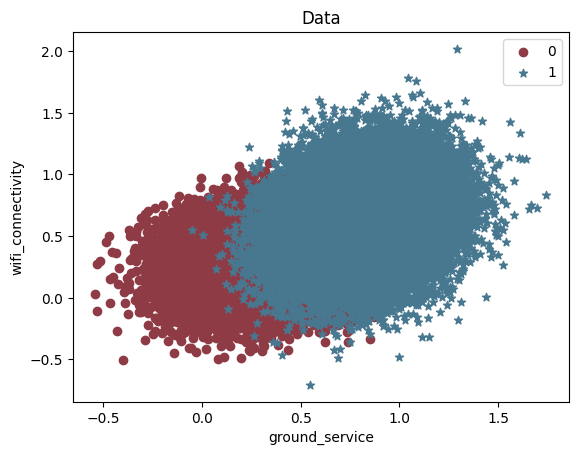

In [ ]:
import matplotlib.pyplot as plt

color = {
    0: '#8e3b46',
    1: '#477890'
}
marker = {
    0: 'o',
    1: '*'
}

plt.figure()
plt.title('Data')
for rec in [0,1]:
    plt.scatter(X[rec][:, 0], X[rec][:, 1], color=color[rec], marker=marker[rec], label=str(rec))
plt.xlabel(f1_name)
plt.ylabel(f2_name)
plt.legend()
plt.show()

#### 2.5.1.2 Fit

In [ ]:
from sklearn.model_selection import train_test_split
from math import sqrt

N_sample = 10_000

NaiveKernel_tuning(XX[:N_sample], YY[:N_sample], minh=0.01, maxh=0.5, nh=10,
                   test_size=0.3, val_size=0.2,
                   best_h_plot_flag=True, verbose=2);

Trying for h=[0.01, 0.016, 0.0342, 0.0644, 0.1068, 0.1612, 0.2278, 0.3064, 0.3972, 0.5]


KeyboardInterrupt: ignored

### 2.5.2 Real DataSet

#### 2.5.2.1 Fit on real data

Fit only with overall and value_for_money

Trying for h=[0.2828, 0.2968, 0.3387, 0.4086, 0.5063, 0.632, 0.7857, 0.9673, 1.1768, 1.4142]
h = 0.2828, MSE =  0.053
h = 0.2968, MSE =  0.056
h = 0.3387, MSE =  0.056
h = 0.4086, MSE =  0.06
h = 0.5063, MSE =  0.076
h = 0.632, MSE =  0.061
h = 0.7857, MSE =  0.094
h = 0.9673, MSE =  0.158
h = 1.1768, MSE =  0.291
h = 1.4142, MSE =  0.48


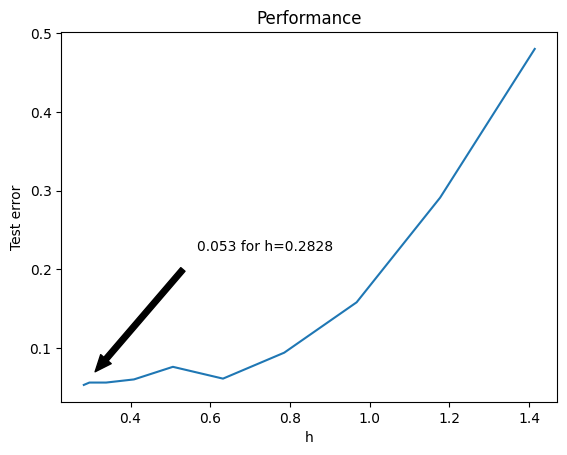

Final performance:  96.20%


In [ ]:
import pandas as pd
from math import sqrt

N_sample = 5_000

X_real = pd.concat([data[f1_name], data[f2_name]], axis=1)
Y_real = data['recommended']

NaiveKernel_tuning(X_real[:N_sample].values, Y_real[:N_sample].values,
                   minh=0.2*sqrt(2), maxh=sqrt(2), nh=10, best_h_plot_flag=True, verbose=2);

Fit with all features (one-by-one)

In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
from tabulate import tabulate

N_sample = 2000

best_h = []
best_mse = []
best_score = []
for feature in features:
    X_real = pd.concat([data[feature]], axis=1)
    Y_real = data['recommended']

    print(f"***\n Fitting with '{feature}' feature")
    h, mse, score = NaiveKernel_tuning(X_real[:N_sample].values, Y_real[:N_sample].values,
                                       minh=0.2*sqrt(2), maxh=0.5*sqrt(2), nh=10,
                                       best_h_plot_flag=True, verbose=2)
    best_h.append(h)
    best_mse.append(mse)
    best_score.append(score)

table = tabulate(np.array([['h'] + [f'{h}' for h in best_h],
                           ['MSE'] + [f'{mse*100:.2f}%' for mse in best_mse],
                           ['Score'] + [f'{score*100:.2f}%' for score in best_score]]),
                 features, tablefmt="fancy_grid")
print(table)

Fit with all features together

In [ ]:
import pandas as pd
import numpy as np

N_sample = 10_000

X_real = pd.concat([data[feature] for feature in features], axis=1)
Y_real = data['recommended']

NaiveKernel_tuning(X_real[:N_sample].values, Y_real[:N_sample].values,
                   minh=0.2*sqrt(2), maxh=0.5*sqrt(2), nh=10,
                   best_h_plot_flag=True, verbose=2)